# hf login

NOTE: must login to huggingface before running.

In [1]:
from huggingface_hub import hf_hub_download, notebook_login
notebook_login()

# setup

In [1]:
%%capture
%pip install sae-lens

In [2]:
import pdb
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset

In [3]:
import gc
import pickle
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import json
from fnmatch import fnmatch
from pathlib import Path
from typing import NamedTuple, Optional, Callable, Union, List, Tuple
# from jaxtyping import Float, Int
from collections import Counter
import seaborn as sns
import pandas as pd

import einops
import torch
from torch import Tensor, nn
from huggingface_hub import snapshot_download
from natsort import natsorted
from safetensors.torch import load_model, save_model

from sae_lens import SAE

device = "cuda" if torch.cuda.is_available() else "cpu"

## corr fns

In [4]:
def normalize_byChunks(actv_tensor, chunk_size=10000): # chunk_size: Number of rows per chunk
    mean_A = actv_tensor.mean(dim=0, keepdim=True)
    std_A = actv_tensor.std(dim=0, keepdim=True)

    num_chunks = actv_tensor.shape[0] // chunk_size

    normalized_A = np.zeros_like(actv_tensor.cpu())  # Preallocate the normalized matrix
    # normalized_A = actv_tensor.new_zeros(actv_tensor.size())

    for i in range(num_chunks):
        # print (i, num_chunks)
        start_index = i * chunk_size
        end_index = start_index + chunk_size
        chunk = actv_tensor[start_index:end_index]
        normalized_A[start_index:end_index] = (chunk - mean_A) / (std_A + 1e-8)

    # Handle any remaining rows if the data size is not perfectly divisible by chunk_size
    if actv_tensor.shape[0] % chunk_size != 0:
        start_index = num_chunks * chunk_size
        chunk = actv_tensor[start_index:]
        normalized_A[start_index:] = (chunk - mean_A) / (std_A + 1e-8)

    return torch.tensor(normalized_A)

In [5]:
def batched_correlation(reshaped_activations_A, reshaped_activations_B, batch_size=100):
    # Ensure tensors are on GPU
    # if torch.cuda.is_available():
    #     reshaped_activations_A = reshaped_activations_A.to('cuda')
    #     reshaped_activations_B = reshaped_activations_B.to('cuda')

    normalized_A = normalize_byChunks(reshaped_activations_A, chunk_size=10000)
    normalized_B = normalize_byChunks(reshaped_activations_B, chunk_size=10000)

    if torch.cuda.is_available():
        normalized_A = normalized_A.to('cuda')
        normalized_B = normalized_B.to('cuda')

    num_batches = (normalized_B.shape[1] + batch_size - 1) // batch_size
    max_values = []
    max_indices = []

    for batch in range(num_batches):
        start = batch * batch_size
        # if start % 5000 == 0:
        #     print(start)
        end = min(start + batch_size, normalized_B.shape[1])

        batch_corr_matrix = torch.matmul(normalized_A.t(), normalized_B[:, start:end]) / normalized_A.shape[0]
        max_val, max_idx = batch_corr_matrix.max(dim=0)
        max_values.append(max_val)
        max_indices.append(max_idx)  # Adjust indices for the batch offset

        del batch_corr_matrix
        torch.cuda.empty_cache()

    # return torch.cat(max_indices), torch.cat(max_values)
    return torch.cat(max_indices).cpu().numpy(), torch.cat(max_values).cpu().numpy()

## sim fns

The following functions are from: https://github.com/mklabunde/resi/tree/main/repsim/measures

In [6]:
import functools
from typing import Any, Callable, Dict, List, Tuple, Union

import numpy as np
import numpy.typing as npt
import torch


def to_numpy_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[npt.NDArray]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> npt.NDArray:
        return x if isinstance(x, np.ndarray) else x.numpy()

    return list(map(convert, args))


def to_torch_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[torch.Tensor]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
        return x if isinstance(x, torch.Tensor) else torch.from_numpy(x)

    return list(map(convert, args))


def adjust_dimensionality(
    R: npt.NDArray, Rp: npt.NDArray, strategy="zero_pad"
) -> Tuple[npt.NDArray, npt.NDArray]:
    D = R.shape[1]
    Dp = Rp.shape[1]
    if strategy == "zero_pad":
        if D - Dp == 0:
            return R, Rp
        elif D - Dp > 0:
            return R, np.concatenate((Rp, np.zeros((Rp.shape[0], D - Dp))), axis=1)
        else:
            return np.concatenate((R, np.zeros((R.shape[0], Dp - D))), axis=1), Rp
    else:
        raise NotImplementedError()


def center_columns(R: npt.NDArray) -> npt.NDArray:
    return R - R.mean(axis=0)[None, :]


def normalize_matrix_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord="fro")


def sim_random_baseline(
    rep1: torch.Tensor, rep2: torch.Tensor, sim_func: Callable, n_permutations: int = 10
) -> Dict[str, Any]:
    torch.manual_seed(1234)
    scores = []
    for _ in range(n_permutations):
        perm = torch.randperm(rep1.size(0))

        score = sim_func(rep1[perm, :], rep2)
        score = score if isinstance(score, float) else score["score"]

        scores.append(score)

    return {"baseline_scores": np.array(scores)}


class Pipeline:
    def __init__(
        self,
        preprocess_funcs: List[Callable[[npt.NDArray], npt.NDArray]],
        similarity_func: Callable[[npt.NDArray, npt.NDArray], Dict[str, Any]],
    ) -> None:
        self.preprocess_funcs = preprocess_funcs
        self.similarity_func = similarity_func

    def __call__(self, R: npt.NDArray, Rp: npt.NDArray) -> Dict[str, Any]:
        for preprocess_func in self.preprocess_funcs:
            R = preprocess_func(R)
            Rp = preprocess_func(Rp)
        return self.similarity_func(R, Rp)

    def __str__(self) -> str:
        def func_name(func: Callable) -> str:
            return (
                func.__name__
                if not isinstance(func, functools.partial)
                else func.func.__name__
            )

        def partial_keywords(func: Callable) -> str:
            if not isinstance(func, functools.partial):
                return ""
            else:
                return str(func.keywords)

        return (
            "Pipeline("
            + (
                "+".join(map(func_name, self.preprocess_funcs))
                + "+"
                + func_name(self.similarity_func)
                + partial_keywords(self.similarity_func)
            )
            + ")"
        )

In [7]:
from typing import List, Set, Union

import numpy as np
import numpy.typing as npt
import sklearn.neighbors
import torch

# from llmcomp.measures.utils import to_numpy_if_needed


def _jac_sim_i(idx_R: Set[int], idx_Rp: Set[int]) -> float:
    return len(idx_R.intersection(idx_Rp)) / len(idx_R.union(idx_Rp))


def jaccard_similarity(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    k: int = 10,
    inner: str = "cosine",
    n_jobs: int = 8,
) -> float:
    R, Rp = to_numpy_if_needed(R, Rp)

    indices_R = nn_array_to_setlist(top_k_neighbors(R, k, inner, n_jobs))
    indices_Rp = nn_array_to_setlist(top_k_neighbors(Rp, k, inner, n_jobs))

    return float(
        np.mean(
            [_jac_sim_i(idx_R, idx_Rp) for idx_R, idx_Rp in zip(indices_R, indices_Rp)]
        )
    )


def top_k_neighbors(
    R: npt.NDArray,
    k: int,
    inner: str,
    n_jobs: int,
) -> npt.NDArray:
    # k+1 nearest neighbors, because we pass in all the data, which means that a point
    # will be the nearest neighbor to itself. We remove this point from the results and
    # report only the k nearest neighbors distinct from the point itself.
    nns = sklearn.neighbors.NearestNeighbors(
        n_neighbors=k + 1, metric=inner, n_jobs=n_jobs
    )
    nns.fit(R)
    _, nns = nns.kneighbors(R)
    return nns[:, 1:]


def nn_array_to_setlist(nn: npt.NDArray) -> List[Set[int]]:
    return [set(idx) for idx in nn]

In [8]:
import functools
import logging
from abc import ABC
from abc import abstractmethod
from dataclasses import dataclass
from dataclasses import field
from typing import Any
from typing import Callable
from typing import get_args
from typing import List
from typing import Literal
from typing import Optional
from typing import Protocol
from typing import Tuple
from typing import Union

import numpy as np
import numpy.typing as npt
import torch
from einops import rearrange
# from loguru import logger

log = logging.getLogger(__name__)


SHAPE_TYPE = Literal["nd", "ntd", "nchw"]

ND_SHAPE, NTD_SHAPE, NCHW_SHAPE = get_args(SHAPE_TYPE)[0], get_args(SHAPE_TYPE)[1], get_args(SHAPE_TYPE)[2]


class SimilarityFunction(Protocol):
    def __call__(  # noqa: E704
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
    ) -> float: ...


class RSMSimilarityFunction(Protocol):
    def __call__(  # noqa: E704
        self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE, n_jobs: int
    ) -> float: ...


@dataclass
class BaseSimilarityMeasure(ABC):
    larger_is_more_similar: bool
    is_symmetric: bool

    is_metric: bool | None = None
    invariant_to_affine: bool | None = None
    invariant_to_invertible_linear: bool | None = None
    invariant_to_ortho: bool | None = None
    invariant_to_permutation: bool | None = None
    invariant_to_isotropic_scaling: bool | None = None
    invariant_to_translation: bool | None = None
    name: str = field(init=False)

    def __post_init__(self):
        self.name = self.__class__.__name__

    @abstractmethod
    def __call__(self, *args: Any, **kwds: Any) -> Any:
        raise NotImplementedError


class FunctionalSimilarityMeasure(BaseSimilarityMeasure):
    @abstractmethod
    def __call__(self, output_a: torch.Tensor | npt.NDArray, output_b: torch.Tensor | npt.NDArray) -> float:
        raise NotImplementedError


@dataclass(kw_only=True)
class RepresentationalSimilarityMeasure(BaseSimilarityMeasure):
    sim_func: SimilarityFunction

    def __call__(
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
    ) -> float:
        return self.sim_func(R, Rp, shape)


class RSMSimilarityMeasure(RepresentationalSimilarityMeasure):
    sim_func: RSMSimilarityFunction

    @staticmethod
    def estimate_good_number_of_jobs(R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray) -> int:
        # RSMs in are NxN (or DxD) so the number of jobs should roughly scale quadratically with increase in N (or D).
        # False! As long as sklearn-native metrics are used, they will use parallel implementations regardless of job
        # count. Each job would spawn their own threads, which leads to oversubscription of cores and thus slowdown.
        # This seems to be not fully correct (n_jobs=2 seems to actually use two cores), but using n_jobs=1 seems the
        # fastest.
        return 1

    def __call__(
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
        n_jobs: Optional[int] = None,
    ) -> float:
        if n_jobs is None:
            n_jobs = self.estimate_good_number_of_jobs(R, Rp)
        return self.sim_func(R, Rp, shape, n_jobs=n_jobs)


def to_numpy_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[npt.NDArray]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> npt.NDArray:
        return x if isinstance(x, np.ndarray) else x.numpy()

    return list(map(convert, args))


def to_torch_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[torch.Tensor]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
        return x if isinstance(x, torch.Tensor) else torch.from_numpy(x)

    return list(map(convert, args))


def adjust_dimensionality(R: npt.NDArray, Rp: npt.NDArray, strategy="zero_pad") -> Tuple[npt.NDArray, npt.NDArray]:
    D = R.shape[1]
    Dp = Rp.shape[1]
    if strategy == "zero_pad":
        if D - Dp == 0:
            return R, Rp
        elif D - Dp > 0:
            return R, np.concatenate((Rp, np.zeros((Rp.shape[0], D - Dp))), axis=1)
        else:
            return np.concatenate((R, np.zeros((R.shape[0], Dp - D))), axis=1), Rp
    else:
        raise NotImplementedError()


def center_columns(R: npt.NDArray) -> npt.NDArray:
    return R - R.mean(axis=0)[None, :]


def normalize_matrix_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord="fro")


def normalize_row_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord=2, axis=1, keepdims=True)


def standardize(R: npt.NDArray) -> npt.NDArray:
    return (R - R.mean(axis=0, keepdims=True)) / R.std(axis=0)


def double_center(x: npt.NDArray) -> npt.NDArray:
    return x - x.mean(axis=0, keepdims=True) - x.mean(axis=1, keepdims=True) + x.mean()


def align_spatial_dimensions(R: npt.NDArray, Rp: npt.NDArray) -> Tuple[npt.NDArray, npt.NDArray]:
    """
    Aligns spatial representations by resizing them to the smallest spatial dimension.
    Subsequent aligned spatial representations are flattened, with the spatial aligned representations
    moving into the *sample* dimension.
    """
    R_re, Rp_re = resize_wh_reps(R, Rp)
    R_re = rearrange(R_re, "n c h w -> (n h w) c")
    Rp_re = rearrange(Rp_re, "n c h w -> (n h w) c")
    if R_re.shape[0] > 5000:
        logger.info(f"Got {R_re.shape[0]} samples in N after flattening. Subsampling to reduce compute.")
        subsample = R_re.shape[0] // 5000
        R_re = R_re[::subsample]
        Rp_re = Rp_re[::subsample]

    return R_re, Rp_re


def average_pool_downsample(R, resize: bool, new_size: tuple[int, int]):
    if not resize:
        return R  # do nothing
    else:
        is_numpy = isinstance(R, np.ndarray)
        R_torch = torch.from_numpy(R) if is_numpy else R
        R_torch = torch.nn.functional.adaptive_avg_pool2d(R_torch, new_size)
        return R_torch.numpy() if is_numpy else R_torch


def resize_wh_reps(R: npt.NDArray, Rp: npt.NDArray) -> Tuple[npt.NDArray, npt.NDArray]:
    """
    Function for resizing spatial representations that are not the same size.
    Does through fourier transform and resizing.

    Args:
        R: numpy array of shape  [batch_size, height, width, num_channels]
        RP: numpy array of shape [batch_size, height, width, num_channels]

    Returns:
        fft_acts1: numpy array of shape [batch_size, (new) height, (new) width, num_channels]
        fft_acts2: numpy array of shape [batch_size, (new) height, (new) width, num_channels]

    """
    height1, width1 = R.shape[2], R.shape[3]
    height2, width2 = Rp.shape[2], Rp.shape[3]
    if height1 != height2 or width1 != width2:
        height = min(height1, height2)
        width = min(width1, width2)
        new_size = [height, width]
        resize = True
    else:
        height = height1
        width = width1
        new_size = None
        resize = False

    # resize and preprocess with fft
    avg_ds1 = average_pool_downsample(R, resize=resize, new_size=new_size)
    avg_ds2 = average_pool_downsample(Rp, resize=resize, new_size=new_size)
    return avg_ds1, avg_ds2


def fft_resize(images, resize=False, new_size=None):
    """Function for applying DFT and resizing.

    This function takes in an array of images, applies the 2-d fourier transform
    and resizes them according to new_size, keeping the frequencies that overlap
    between the two sizes.

    Args:
              images: a numpy array with shape
                      [batch_size, height, width, num_channels]
              resize: boolean, whether or not to resize
              new_size: a tuple (size, size), with height and width the same

    Returns:
              im_fft_downsampled: a numpy array with shape
                           [batch_size, (new) height, (new) width, num_channels]
    """
    assert len(images.shape) == 4, "expecting images to be" "[batch_size, height, width, num_channels]"
    if resize:
        # FFT --> remove high frequencies --> inverse FFT
        im_complex = images.astype("complex64")
        im_fft = np.fft.fft2(im_complex, axes=(1, 2))
        im_shifted = np.fft.fftshift(im_fft, axes=(1, 2))

        center_width = im_shifted.shape[2] // 2
        center_height = im_shifted.shape[1] // 2
        half_w = new_size[0] // 2
        half_h = new_size[1] // 2
        cropped_fft = im_shifted[
            :, center_height - half_h : center_height + half_h, center_width - half_w : center_width + half_w, :
        ]
        cropped_fft_shifted_back = np.fft.ifft2(cropped_fft, axes=(1, 2))
        return cropped_fft_shifted_back.real
    else:
        return images


class Pipeline:
    def __init__(
        self,
        preprocess_funcs: List[Callable[[npt.NDArray], npt.NDArray]],
        similarity_func: Callable[[npt.NDArray, npt.NDArray, SHAPE_TYPE], float],
    ) -> None:
        self.preprocess_funcs = preprocess_funcs
        self.similarity_func = similarity_func

    def __call__(self, R: npt.NDArray, Rp: npt.NDArray, shape: SHAPE_TYPE) -> float:
        try:
            for preprocess_func in self.preprocess_funcs:
                R = preprocess_func(R)
                Rp = preprocess_func(Rp)
            return self.similarity_func(R, Rp, shape)
        except ValueError as e:
            log.info(f"Pipeline failed: {e}")
            return np.nan

    def __str__(self) -> str:
        def func_name(func: Callable) -> str:
            return func.__name__ if not isinstance(func, functools.partial) else func.func.__name__

        def partial_keywords(func: Callable) -> str:
            if not isinstance(func, functools.partial):
                return ""
            else:
                return str(func.keywords)

        return (
            "Pipeline("
            + (
                "+".join(map(func_name, self.preprocess_funcs))
                + "+"
                + func_name(self.similarity_func)
                + partial_keywords(self.similarity_func)
            )
            + ")"
        )


def flatten(*args: Union[torch.Tensor, npt.NDArray], shape: SHAPE_TYPE) -> List[Union[torch.Tensor, npt.NDArray]]:
    if shape == "ntd":
        return list(map(flatten_nxtxd_to_ntxd, args))
    elif shape == "nd":
        return list(args)
    elif shape == "nchw":
        return list(map(flatten_nxcxhxw_to_nxchw, args))  # Flattening non-trivial for nchw
    else:
        raise ValueError("Unknown shape of representations. Must be one of 'ntd', 'nchw', 'nd'.")


def flatten_nxtxd_to_ntxd(R: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
    R = to_torch_if_needed(R)[0]
    log.debug("Shape before flattening: %s", str(R.shape))
    R = torch.flatten(R, start_dim=0, end_dim=1)
    log.debug("Shape after flattening: %s", str(R.shape))
    return R


def flatten_nxcxhxw_to_nxchw(R: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
    R = to_torch_if_needed(R)[0]
    log.debug("Shape before flattening: %s", str(R.shape))
    R = torch.reshape(R, (R.shape[0], -1))
    log.debug("Shape after flattening: %s", str(R.shape))
    return R

In [9]:
import scipy.optimize

def permutation_procrustes(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
    optimal_permutation_alignment: Optional[Tuple[npt.NDArray, npt.NDArray]] = None,
) -> float:
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)
    R, Rp = adjust_dimensionality(R, Rp)

    if not optimal_permutation_alignment:
        PR, PRp = scipy.optimize.linear_sum_assignment(R.T @ Rp, maximize=True)  # returns column assignments
        optimal_permutation_alignment = (PR, PRp)
    PR, PRp = optimal_permutation_alignment
    return float(np.linalg.norm(R[:, PR] - Rp[:, PRp], ord="fro"))

In [10]:
from typing import Optional
from typing import Union

import numpy as np
import numpy.typing as npt
import scipy.spatial.distance
import scipy.stats
import sklearn.metrics
import torch
# from repsim.measures.utils import flatten
# from repsim.measures.utils import RSMSimilarityMeasure
# from repsim.measures.utils import SHAPE_TYPE
# from repsim.measures.utils import to_numpy_if_needed


def representational_similarity_analysis(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
    inner="correlation",
    outer="spearman",
    n_jobs: Optional[int] = None,
) -> float:
    """Representational similarity analysis

    Args:
        R (Union[torch.Tensor, npt.NDArray]): N x D representation
        Rp (Union[torch.Tensor, npt.NDArray]): N x D' representation
        inner (str, optional): inner similarity function for RSM. Must be one of
            scipy.spatial.distance.pdist identifiers . Defaults to "correlation".
        outer (str, optional): outer similarity function that compares RSMs. Defaults to
             "spearman". Must be one of "spearman", "euclidean"

    Returns:
        float: _description_
    """
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)

    if inner == "correlation":
        # n_jobs only works if metric is in PAIRWISE_DISTANCES as defined in sklearn, i.e., not for correlation.
        # But correlation = 1 - cosine dist of row-centered data, so we use the faster cosine metric and center the data.
        R = R - R.mean(axis=1, keepdims=True)
        S = scipy.spatial.distance.squareform(  # take the lower triangle of RSM
            1 - sklearn.metrics.pairwise_distances(R, metric="cosine", n_jobs=n_jobs),  # type:ignore
            checks=False,
        )
        Rp = Rp - Rp.mean(axis=1, keepdims=True)
        Sp = scipy.spatial.distance.squareform(
            1 - sklearn.metrics.pairwise_distances(Rp, metric="cosine", n_jobs=n_jobs),  # type:ignore
            checks=False,
        )
    elif inner == "euclidean":
        # take the lower triangle of RSM
        S = scipy.spatial.distance.squareform(
            sklearn.metrics.pairwise_distances(R, metric=inner, n_jobs=n_jobs), checks=False
        )
        Sp = scipy.spatial.distance.squareform(
            sklearn.metrics.pairwise_distances(Rp, metric=inner, n_jobs=n_jobs), checks=False
        )
    else:
        raise NotImplementedError(f"{inner=}")

    if outer == "spearman":
        return scipy.stats.spearmanr(S, Sp).statistic  # type:ignore
    elif outer == "euclidean":
        return float(np.linalg.norm(S - Sp, ord=2))
    else:
        raise ValueError(f"Unknown outer similarity function: {outer}")


class RSA(RSMSimilarityMeasure):
    def __init__(self):
        # choice of inner/outer in __call__ if fixed to default values, so these values are always the same
        super().__init__(
            sim_func=representational_similarity_analysis,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=True,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=False,
            invariant_to_permutation=True,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

In [11]:
##################################################################################
# Copied from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/cca_core.py
# Copyright 2018 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""
The core code for applying Canonical Correlation Analysis to deep networks.

This module contains the core functions to apply canonical correlation analysis
to deep neural networks. The main function is get_cca_similarity, which takes in
two sets of activations, typically the neurons in two layers and their outputs
on all of the datapoints D = [d_1,...,d_m] that have been passed through.

Inputs have shape (num_neurons1, m), (num_neurons2, m). This can be directly
applied used on fully connected networks. For convolutional layers, the 3d block
of neurons can either be flattened entirely, along channels, or alternatively,
the dft_ccas (Discrete Fourier Transform) module can be used.

See:
https://arxiv.org/abs/1706.05806
https://arxiv.org/abs/1806.05759
for full details.

"""
import numpy as np
# from repsim.measures.utils import align_spatial_dimensions

num_cca_trials = 5


def positivedef_matrix_sqrt(array):
    """Stable method for computing matrix square roots, supports complex matrices.

    Args:
              array: A numpy 2d array, can be complex valued that is a positive
                     definite symmetric (or hermitian) matrix

    Returns:
              sqrtarray: The matrix square root of array
    """
    w, v = np.linalg.eigh(array)
    #  A - np.dot(v, np.dot(np.diag(w), v.T))
    wsqrt = np.sqrt(w)
    sqrtarray = np.dot(v, np.dot(np.diag(wsqrt), np.conj(v).T))
    return sqrtarray


def remove_small(sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon):
    """Takes covariance between X, Y, and removes values of small magnitude.

    Args:
              sigma_xx: 2d numpy array, variance matrix for x
              sigma_xy: 2d numpy array, crossvariance matrix for x,y
              sigma_yx: 2d numpy array, crossvariance matrixy for x,y,
                        (conjugate) transpose of sigma_xy
              sigma_yy: 2d numpy array, variance matrix for y
              epsilon : cutoff value for norm below which directions are thrown
                         away

    Returns:
              sigma_xx_crop: 2d array with low x norm directions removed
              sigma_xy_crop: 2d array with low x and y norm directions removed
              sigma_yx_crop: 2d array with low x and y norm directiosn removed
              sigma_yy_crop: 2d array with low y norm directions removed
              x_idxs: indexes of sigma_xx that were removed
              y_idxs: indexes of sigma_yy that were removed
    """

    x_diag = np.abs(np.diagonal(sigma_xx))
    y_diag = np.abs(np.diagonal(sigma_yy))
    x_idxs = x_diag >= epsilon
    y_idxs = y_diag >= epsilon

    sigma_xx_crop = sigma_xx[x_idxs][:, x_idxs]
    sigma_xy_crop = sigma_xy[x_idxs][:, y_idxs]
    sigma_yx_crop = sigma_yx[y_idxs][:, x_idxs]
    sigma_yy_crop = sigma_yy[y_idxs][:, y_idxs]

    return (sigma_xx_crop, sigma_xy_crop, sigma_yx_crop, sigma_yy_crop, x_idxs, y_idxs)


def compute_ccas(sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon, verbose=True):
    """Main cca computation function, takes in variances and crossvariances.

    This function takes in the covariances and cross covariances of X, Y,
    preprocesses them (removing small magnitudes) and outputs the raw results of
    the cca computation, including cca directions in a rotated space, and the
    cca correlation coefficient values.

    Args:
              sigma_xx: 2d numpy array, (num_neurons_x, num_neurons_x)
                        variance matrix for x
              sigma_xy: 2d numpy array, (num_neurons_x, num_neurons_y)
                        crossvariance matrix for x,y
              sigma_yx: 2d numpy array, (num_neurons_y, num_neurons_x)
                        crossvariance matrix for x,y (conj) transpose of sigma_xy
              sigma_yy: 2d numpy array, (num_neurons_y, num_neurons_y)
                        variance matrix for y
              epsilon:  small float to help with stabilizing computations
              verbose:  boolean on whether to print intermediate outputs

    Returns:
              [ux, sx, vx]: [numpy 2d array, numpy 1d array, numpy 2d array]
                            ux and vx are (conj) transposes of each other, being
                            the canonical directions in the X subspace.
                            sx is the set of canonical correlation coefficients-
                            how well corresponding directions in vx, Vy correlate
                            with each other.
              [uy, sy, vy]: Same as above, but for Y space
              invsqrt_xx:   Inverse square root of sigma_xx to transform canonical
                            directions back to original space
              invsqrt_yy:   Same as above but for sigma_yy
              x_idxs:       The indexes of the input sigma_xx that were pruned
                            by remove_small
              y_idxs:       Same as above but for sigma_yy
    """

    (sigma_xx, sigma_xy, sigma_yx, sigma_yy, x_idxs, y_idxs) = remove_small(
        sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon
    )

    numx = sigma_xx.shape[0]
    numy = sigma_yy.shape[0]

    if numx == 0 or numy == 0:
        return (
            [0, 0, 0],
            [0, 0, 0],
            np.zeros_like(sigma_xx),
            np.zeros_like(sigma_yy),
            x_idxs,
            y_idxs,
        )

    if verbose:
        print("adding eps to diagonal and taking inverse")
    sigma_xx += epsilon * np.eye(numx)
    sigma_yy += epsilon * np.eye(numy)
    inv_xx = np.linalg.pinv(sigma_xx)
    inv_yy = np.linalg.pinv(sigma_yy)

    if verbose:
        print("taking square root")
    invsqrt_xx = positivedef_matrix_sqrt(inv_xx)
    invsqrt_yy = positivedef_matrix_sqrt(inv_yy)

    if verbose:
        print("dot products...")
    arr = np.dot(invsqrt_xx, np.dot(sigma_xy, invsqrt_yy))

    if verbose:
        print("trying to take final svd")
    u, s, v = np.linalg.svd(arr)

    if verbose:
        print("computed everything!")

    return [u, np.abs(s), v], invsqrt_xx, invsqrt_yy, x_idxs, y_idxs


def sum_threshold(array, threshold):
    """Computes threshold index of decreasing nonnegative array by summing.

    This function takes in a decreasing array nonnegative floats, and a
    threshold between 0 and 1. It returns the index i at which the sum of the
    array up to i is threshold*total mass of the array.

    Args:
              array: a 1d numpy array of decreasing, nonnegative floats
              threshold: a number between 0 and 1

    Returns:
              i: index at which np.sum(array[:i]) >= threshold
    """
    assert (threshold >= 0) and (threshold <= 1), "print incorrect threshold"

    for i in range(len(array)):
        if np.sum(array[:i]) / np.sum(array) >= threshold:
            return i


def create_zero_dict(compute_dirns, dimension):
    """Outputs a zero dict when neuron activation norms too small.

    This function creates a return_dict with appropriately shaped zero entries
    when all neuron activations are very small.

    Args:
              compute_dirns: boolean, whether to have zero vectors for directions
              dimension: int, defines shape of directions

    Returns:
              return_dict: a dict of appropriately shaped zero entries
    """
    return_dict = {}
    return_dict["mean"] = (np.asarray(0), np.asarray(0))
    return_dict["sum"] = (np.asarray(0), np.asarray(0))
    return_dict["cca_coef1"] = np.asarray(0)
    return_dict["cca_coef2"] = np.asarray(0)
    return_dict["idx1"] = 0
    return_dict["idx2"] = 0

    if compute_dirns:
        return_dict["cca_dirns1"] = np.zeros((1, dimension))
        return_dict["cca_dirns2"] = np.zeros((1, dimension))

    return return_dict


def get_cca_similarity(
    acts1,
    acts2,
    epsilon=0.0,
    threshold=0.98,
    compute_coefs=True,
    compute_dirns=False,
    verbose=True,
):
    """The main function for computing cca similarities.

    This function computes the cca similarity between two sets of activations,
    returning a dict with the cca coefficients, a few statistics of the cca
    coefficients, and (optionally) the actual directions.

    Args:
              acts1: (num_neurons1, data_points) a 2d numpy array of neurons by
                     datapoints where entry (i,j) is the output of neuron i on
                     datapoint j.
              acts2: (num_neurons2, data_points) same as above, but (potentially)
                     for a different set of neurons. Note that acts1 and acts2
                     can have different numbers of neurons, but must agree on the
                     number of datapoints

              epsilon: small float to help stabilize computations

              threshold: float between 0, 1 used to get rid of trailing zeros in
                         the cca correlation coefficients to output more accurate
                         summary statistics of correlations.


              compute_coefs: boolean value determining whether coefficients
                             over neurons are computed. Needed for computing
                             directions

              compute_dirns: boolean value determining whether actual cca
                             directions are computed. (For very large neurons and
                             datasets, may be better to compute these on the fly
                             instead of store in memory.)

              verbose: Boolean, whether intermediate outputs are printed

    Returns:
              return_dict: A dictionary with outputs from the cca computations.
                           Contains neuron coefficients (combinations of neurons
                           that correspond to cca directions), the cca correlation
                           coefficients (how well aligned directions correlate),
                           x and y idxs (for computing cca directions on the fly
                           if compute_dirns=False), and summary statistics. If
                           compute_dirns=True, the cca directions are also
                           computed.
    """

    # assert dimensionality equal
    assert acts1.shape[1] == acts2.shape[1], "dimensions don't match"
    # check that acts1, acts2 are transposition
    assert acts1.shape[0] < acts1.shape[1], "input must be number of neurons" "by datapoints"
    return_dict = {}

    # compute covariance with numpy function for extra stability
    numx = acts1.shape[0]
    numy = acts2.shape[0]

    covariance = np.cov(acts1, acts2)
    sigmaxx = covariance[:numx, :numx]
    sigmaxy = covariance[:numx, numx:]
    sigmayx = covariance[numx:, :numx]
    sigmayy = covariance[numx:, numx:]

    # rescale covariance to make cca computation more stable
    xmax = np.max(np.abs(sigmaxx))
    ymax = np.max(np.abs(sigmayy))
    sigmaxx /= xmax
    sigmayy /= ymax
    sigmaxy /= np.sqrt(xmax * ymax)
    sigmayx /= np.sqrt(xmax * ymax)

    ([u, s, v], invsqrt_xx, invsqrt_yy, x_idxs, y_idxs) = compute_ccas(
        sigmaxx, sigmaxy, sigmayx, sigmayy, epsilon=epsilon, verbose=verbose
    )

    # if x_idxs or y_idxs is all false, return_dict has zero entries
    if (not np.any(x_idxs)) or (not np.any(y_idxs)):
        return create_zero_dict(compute_dirns, acts1.shape[1])

    if compute_coefs:
        # also compute full coefficients over all neurons
        x_mask = np.dot(x_idxs.reshape((-1, 1)), x_idxs.reshape((1, -1)))
        y_mask = np.dot(y_idxs.reshape((-1, 1)), y_idxs.reshape((1, -1)))

        return_dict["coef_x"] = u.T
        return_dict["invsqrt_xx"] = invsqrt_xx
        return_dict["full_coef_x"] = np.zeros((numx, numx))
        np.place(return_dict["full_coef_x"], x_mask, return_dict["coef_x"])
        return_dict["full_invsqrt_xx"] = np.zeros((numx, numx))
        np.place(return_dict["full_invsqrt_xx"], x_mask, return_dict["invsqrt_xx"])

        return_dict["coef_y"] = v
        return_dict["invsqrt_yy"] = invsqrt_yy
        return_dict["full_coef_y"] = np.zeros((numy, numy))
        np.place(return_dict["full_coef_y"], y_mask, return_dict["coef_y"])
        return_dict["full_invsqrt_yy"] = np.zeros((numy, numy))
        np.place(return_dict["full_invsqrt_yy"], y_mask, return_dict["invsqrt_yy"])

        # compute means
        neuron_means1 = np.mean(acts1, axis=1, keepdims=True)
        neuron_means2 = np.mean(acts2, axis=1, keepdims=True)
        return_dict["neuron_means1"] = neuron_means1
        return_dict["neuron_means2"] = neuron_means2

    if compute_dirns:
        # orthonormal directions that are CCA directions
        cca_dirns1 = (
            np.dot(
                np.dot(return_dict["full_coef_x"], return_dict["full_invsqrt_xx"]),
                (acts1 - neuron_means1),
            )
            + neuron_means1
        )
        cca_dirns2 = (
            np.dot(
                np.dot(return_dict["full_coef_y"], return_dict["full_invsqrt_yy"]),
                (acts2 - neuron_means2),
            )
            + neuron_means2
        )

    # get rid of trailing zeros in the cca coefficients
    idx1 = sum_threshold(s, threshold)
    idx2 = sum_threshold(s, threshold)

    return_dict["cca_coef1"] = s
    return_dict["cca_coef2"] = s
    return_dict["x_idxs"] = x_idxs
    return_dict["y_idxs"] = y_idxs
    # summary statistics
    return_dict["mean"] = (np.mean(s[:idx1]), np.mean(s[:idx2]))
    return_dict["sum"] = (np.sum(s), np.sum(s))

    if compute_dirns:
        return_dict["cca_dirns1"] = cca_dirns1
        return_dict["cca_dirns2"] = cca_dirns2

    return return_dict


def robust_cca_similarity(acts1, acts2, threshold=0.98, epsilon=1e-6, compute_dirns=True):
    """Calls get_cca_similarity multiple times while adding noise.

    This function is very similar to get_cca_similarity, and can be used if
    get_cca_similarity doesn't converge for some pair of inputs. This function
    adds some noise to the activations to help convergence.

    Args:
              acts1: (num_neurons1, data_points) a 2d numpy array of neurons by
                     datapoints where entry (i,j) is the output of neuron i on
                     datapoint j.
              acts2: (num_neurons2, data_points) same as above, but (potentially)
                     for a different set of neurons. Note that acts1 and acts2
                     can have different numbers of neurons, but must agree on the
                     number of datapoints

              threshold: float between 0, 1 used to get rid of trailing zeros in
                         the cca correlation coefficients to output more accurate
                         summary statistics of correlations.

              epsilon: small float to help stabilize computations

              compute_dirns: boolean value determining whether actual cca
                             directions are computed. (For very large neurons and
                             datasets, may be better to compute these on the fly
                             instead of store in memory.)

    Returns:
              return_dict: A dictionary with outputs from the cca computations.
                           Contains neuron coefficients (combinations of neurons
                           that correspond to cca directions), the cca correlation
                           coefficients (how well aligned directions correlate),
                           x and y idxs (for computing cca directions on the fly
                           if compute_dirns=False), and summary statistics. If
                           compute_dirns=True, the cca directions are also
                           computed.
    """

    for trial in range(num_cca_trials):
        try:
            return_dict = get_cca_similarity(acts1, acts2, threshold, compute_dirns)
        except np.linalg.LinAlgError:
            acts1 = acts1 * 1e-1 + np.random.normal(size=acts1.shape) * epsilon
            acts2 = acts2 * 1e-1 + np.random.normal(size=acts1.shape) * epsilon
            if trial + 1 == num_cca_trials:
                raise

    return return_dict
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/cca_core.py


def top_k_pca_comps(singular_values, threshold=0.99):
    total_variance = np.sum(singular_values**2)
    explained_variance = (singular_values**2) / total_variance
    cumulative_variance = np.cumsum(explained_variance)
    return np.argmax(cumulative_variance >= threshold * total_variance) + 1


def _svcca_original(acts1, acts2):
    # Copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/tutorials/001_Introduction.ipynb
    # Modification: get_cca_similarity is in the same file.
    # Modification: top-k PCA component selection s.t. explained variance > 0.99 total variance
    # Mean subtract activations
    cacts1 = acts1 - np.mean(acts1, axis=1, keepdims=True)
    cacts2 = acts2 - np.mean(acts2, axis=1, keepdims=True)

    # Perform SVD
    U1, s1, V1 = np.linalg.svd(cacts1, full_matrices=False)
    U2, s2, V2 = np.linalg.svd(cacts2, full_matrices=False)

    # top-k PCA components only
    k1 = top_k_pca_comps(s1)
    k2 = top_k_pca_comps(s2)

    svacts1 = np.dot(s1[:k1] * np.eye(k1), V1[:k1])
    # can also compute as svacts1 = np.dot(U1.T[:20], cacts1)
    svacts2 = np.dot(s2[:k2] * np.eye(k2), V2[:k2])
    # can also compute as svacts1 = np.dot(U2.T[:20], cacts2)

    svcca_results = get_cca_similarity(svacts1, svacts2, epsilon=1e-10, verbose=False)
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/tutorials/001_Introduction.ipynb
    return np.mean(svcca_results["cca_coef1"])


# Copied from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/pwcca.py
# Modification: get_cca_similarity is in the same file.
def compute_pwcca(acts1, acts2, epsilon=0.0):
    """Computes projection weighting for weighting CCA coefficients

    Args:
         acts1: 2d numpy array, shaped (neurons, num_datapoints)
         acts2: 2d numpy array, shaped (neurons, num_datapoints)

    Returns:
         Original cca coefficient mean and weighted mean

    """
    sresults = get_cca_similarity(
        acts1,
        acts2,
        epsilon=epsilon,
        compute_dirns=False,
        compute_coefs=True,
        verbose=False,
    )
    if np.sum(sresults["x_idxs"]) <= np.sum(sresults["y_idxs"]):
        dirns = (
            np.dot(
                sresults["coef_x"],
                (acts1[sresults["x_idxs"]] - sresults["neuron_means1"][sresults["x_idxs"]]),
            )
            + sresults["neuron_means1"][sresults["x_idxs"]]
        )
        coefs = sresults["cca_coef1"]
        acts = acts1
        idxs = sresults["x_idxs"]
    else:
        dirns = (
            np.dot(
                sresults["coef_y"],
                (acts1[sresults["y_idxs"]] - sresults["neuron_means2"][sresults["y_idxs"]]),
            )
            + sresults["neuron_means2"][sresults["y_idxs"]]
        )
        coefs = sresults["cca_coef2"]
        acts = acts2
        idxs = sresults["y_idxs"]
    P, _ = np.linalg.qr(dirns.T)
    weights = np.sum(np.abs(np.dot(P.T, acts[idxs].T)), axis=1)
    weights = weights / np.sum(weights)

    return np.sum(weights * coefs), weights, coefs
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/pwcca.py


##################################################################################

from typing import Union  # noqa:e402

import numpy.typing as npt  # noqa:e402
import torch  # noqa:e402

# from repsim.measures.utils import (
#     SHAPE_TYPE,
#     flatten,
#     resize_wh_reps,
#     to_numpy_if_needed,
#     RepresentationalSimilarityMeasure,
# )  # noqa:e402


def svcca(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
) -> float:
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)
    return _svcca_original(R.T, Rp.T)


def pwcca(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
) -> float:
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)
    return compute_pwcca(R.T, Rp.T)[0]


class SVCCA(RepresentationalSimilarityMeasure):
    def __init__(self):
        super().__init__(
            sim_func=svcca,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=True,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=True,
            invariant_to_permutation=True,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

    def __call__(self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE) -> float:
        if shape == "nchw":
            # Move spatial dimensions into the sample dimension
            # If not the same spatial dimension, resample via FFT.
            R, Rp = align_spatial_dimensions(R, Rp)
            shape = "nd"

        return self.sim_func(R, Rp, shape)


class PWCCA(RepresentationalSimilarityMeasure):
    def __init__(self):
        super().__init__(
            sim_func=pwcca,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=False,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=False,
            invariant_to_permutation=False,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

    def __call__(self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE) -> float:
        if shape == "nchw":
            # Move spatial dimensions into the sample dimension
            # If not the same spatial dimension, resample via FFT.
            R, Rp = align_spatial_dimensions(R, Rp)
            shape = "nd"

        return self.sim_func(R, Rp, shape)

## get rand

In [12]:
def score_rand(num_runs, weight_matrix_np, weight_matrix_2, num_feats, sim_fn, shapereq_bool):
    all_rand_scores = []
    i = 0
    # for i in range(num_runs):
    while i < num_runs:
        try:
            rand_modA_feats = np.random.choice(range(weight_matrix_np.shape[0]), size=num_feats, replace=False).tolist()
            rand_modB_feats = np.random.choice(range(weight_matrix_2.shape[0]), size=num_feats, replace=False).tolist()

            if shapereq_bool:
                score = sim_fn(weight_matrix_np[rand_modA_feats], weight_matrix_2[rand_modB_feats], "nd")
            else:
                score = sim_fn(weight_matrix_np[rand_modA_feats], weight_matrix_2[rand_modB_feats])
            all_rand_scores.append(score)
            i += 1
        except:
            continue
    return sum(all_rand_scores) / len(all_rand_scores)

In [13]:
import random
def shuffle_rand(num_runs, weight_matrix_np, weight_matrix_2, num_feats, sim_fn, shapereq_bool):
    all_rand_scores = []
    for i in range(num_runs):
        row_idxs = list(range(num_feats))
        random.shuffle(row_idxs)
        if shapereq_bool:
            score = sim_fn(weight_matrix_np, weight_matrix_2[row_idxs], "nd")
        else:
            score = sim_fn(weight_matrix_np, weight_matrix_2[row_idxs])
        all_rand_scores.append(score)
    # return sum(all_rand_scores) / len(all_rand_scores)
    return all_rand_scores

## plot fns

In [14]:
def plot_svcca_byLayer(layer_to_dictscores):
    for key, sub_dict in layer_to_dictscores.items():
        for sub_key, value in sub_dict.items():
            sub_dict[sub_key] = round(value, 4)

    layers = [f'L{i}' for i in range(0, 12)]
    paired_values = [layer_to_dictscores[i]['svcca_paired'] for i in range(0, 12)]
    unpaired_values = [layer_to_dictscores[i]['svcca_rand_mean'] for i in range(0, 12)]

    # Plotting configuration
    x = np.arange(len(layers))  # label locations
    width = 0.35  # width of the bars

    # Increase figure size
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')
    rects2 = ax.bar(x + width/2, unpaired_values, width, label='Unpaired')

    # Adding labels, title and custom x-axis tick labels
    ax.set_ylabel('SVCCA')
    ax.set_title(f'SAEs comparison by Pythia 70m MLP{layer_id} vs 160m MLP Layers')
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
    ax.legend()

    # Rotate labels and adjust padding
    def label_bars(rects):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            # if i % 2 == 0:  # Label every other bar above
            ax.text(rect.get_x() + rect.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=12) # , rotation=90
            # else:  # Label every other bar below
            #     ax.text(rect.get_x() + rect.get_width()/2., 0,
            #             f'{height:.3f}',
            #             ha='center', va='top', rotation=90)

    label_bars(rects1)
    label_bars(rects2)

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    plt.show()

In [15]:
def plot_rsa_byLayer(layer_to_dictscores):
    for key, sub_dict in layer_to_dictscores.items():
        for sub_key, value in sub_dict.items():
            sub_dict[sub_key] = round(value, 4)

    layers = [f'L{i}' for i in range(0, 12)]
    paired_values = [layer_to_dictscores[i]['rsa_paired'] for i in range(0, 12)]
    unpaired_values = [layer_to_dictscores[i]['rsa_rand_mean'] for i in range(0, 12)]

    # Plotting configuration
    x = np.arange(len(layers))  # label locations
    width = 0.35  # width of the bars

    # Increase figure size
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')
    rects2 = ax.bar(x + width/2, unpaired_values, width, label='Unpaired')

    # Adding labels, title and custom x-axis tick labels
    ax.set_ylabel('RSA')
    ax.set_title(f'SAEs comparison by Pythia 70m MLP{layer_id} vs 160m MLP Layers')
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
    ax.legend()

    # Rotate labels and adjust padding
    def label_bars(rects):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            # if i % 2 == 0:  # Label every other bar above
            ax.text(rect.get_x() + rect.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=12) # , rotation=90
            # else:  # Label every other bar below
            #     ax.text(rect.get_x() + rect.get_width()/2., 0,
            #             f'{height:.3f}',
            #             ha='center', va='top', rotation=90)

    label_bars(rects1)
    label_bars(rects2)

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    plt.show()

In [16]:
def plot_meanCorr_byLayer(layer_to_dictscores):
    for key, sub_dict in layer_to_dictscores.items():
        for sub_key, value in sub_dict.items():
            sub_dict[sub_key] = round(value, 4)

    layers = [f'L{i}' for i in range(0, 12)]
    paired_values = [layer_to_dictscores[i]['mean_actv_corr'] for i in range(0, 12)]
    # unpaired_values = [layer_to_dictscores[i]['svcca_unpaired'] for i in range(0, 12)]

    # Plotting configuration
    x = np.arange(len(layers))  # label locations
    width = 0.35  # width of the bars

    # Increase figure size
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')
    # rects2 = ax.bar(x + width/2, unpaired_values, width, label='Unpaired')

    # Adding labels, title and custom x-axis tick labels
    ax.set_ylabel('Corr')
    ax.set_title(f'SAEs comparison by Pythia 70m MLP{layer_id} vs 160m MLP Layers')
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
    ax.legend()

    # Rotate labels and adjust padding
    def label_bars(rects):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            # if i % 2 == 0:  # Label every other bar above
            ax.text(rect.get_x() + rect.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=12) # , rotation=90
            # else:  # Label every other bar below
            #     ax.text(rect.get_x() + rect.get_width()/2., 0,
            #             f'{height:.3f}',
            #             ha='center', va='top', rotation=90)

    label_bars(rects1)
    # label_bars(rects2)

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    plt.show()

In [17]:
def plot_meanCorr_filt_byLayer(layer_to_dictscores):
    for key, sub_dict in layer_to_dictscores.items():
        for sub_key, value in sub_dict.items():
            sub_dict[sub_key] = round(value, 4)

    layers = [f'L{i}' for i in range(0, 12)]
    paired_values = [layer_to_dictscores[i]['mean_actv_corr_filt'] for i in range(0, 12)]

    x = np.arange(len(layers))  # label locations
    width = 0.35  # width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')

    ax.set_ylabel('Corr')
    ax.set_title(f'SAEs comparison by Pythia 70m MLP{layer_id} vs 160m MLP Layers')
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
    ax.legend()

    def label_bars(rects):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=12)

    label_bars(rects1)
    plt.tight_layout()

    plt.show()

In [18]:
def plot_numFeats_afterFilt_byLayer(layer_to_dictscores):
    for key, sub_dict in layer_to_dictscores.items():
        for sub_key, value in sub_dict.items():
            sub_dict[sub_key] = round(value, 4)

    layers = [f'L{i}' for i in range(0, 12)]
    paired_values = [layer_to_dictscores[i]['num_feat_filt'] for i in range(0, 12)]

    x = np.arange(len(layers))  # label locations
    width = 0.35  # width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')

    ax.set_ylabel('Num Feats Kept')
    ax.set_title(f'SAEs comparison by Pythia 70m MLP{layer_id} vs 160m MLP Layers')
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
    ax.legend()

    def label_bars(rects):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=12)

    label_bars(rects1)
    plt.tight_layout()

    plt.show()

In [19]:
# def plot_js_byLayer(layer_to_dictscores):
#     for key, sub_dict in layer_to_dictscores.items():
#         for sub_key, value in sub_dict.items():
#             sub_dict[sub_key] = round(value, 4)

#     layers = [f'L{i}' for i in range(0, 12)]
#     paired_values = [layer_to_dictscores[i]['1-1 jaccard_paired'] for i in range(0, 12)]
#     unpaired_values = [layer_to_dictscores[i]['1-1 jaccard_unpaired'] for i in range(0, 12)]

#     # Plotting configuration
#     x = np.arange(len(layers))  # label locations
#     width = 0.35  # width of the bars

#     # Increase figure size
#     fig, ax = plt.subplots(figsize=(12, 7))  # Slightly increased figure size
#     rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')
#     rects2 = ax.bar(x + width/2, unpaired_values, width, label='Unpaired')

#     # Adding labels, title and custom x-axis tick labels
#     ax.set_ylabel('Jaccard NN')
#     ax.set_title('SAEs comparison by Pythia 70m MLP0 vs 160m MLP Layers')
#     ax.set_xticks(x)
#     ax.set_xticklabels(layers)
#     ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
#     ax.legend()

#     # Label bars with increased font size and different positioning for paired and unpaired
#     def label_bars(rects, is_paired):
#         for rect in rects:
#             height = rect.get_height()
#             label_height = height + 0.05 if is_paired else height + 0.01
#             ax.text(rect.get_x() + rect.get_width()/2., label_height,
#                     f'{height:.3f}',
#                     ha='center', va='bottom', fontsize=9)  # Increased font size to 12

#     label_bars(rects1, True)   # Paired bars
#     label_bars(rects2, False)  # Unpaired bars

#     # Adjust layout to prevent cutting off labels
#     plt.tight_layout()

#     # Increase y-axis limit to accommodate higher labels
#     ax.set_ylim(0, 1.1)  # Increased from 1 to 1.1

#     plt.show()

## interpret fns

In [20]:
def highest_activating_tokens(
    feature_acts,
    feature_idx: int,
    k: int = 10,  # num batch_seq samples
    batch_tokens=None
): # -> Tuple[Int[Tensor, "k 2"], Float[Tensor, "k"]]:
    '''
    Returns the indices & values for the highest-activating tokens in the given batch of data.
    '''
    batch_size, seq_len = batch_tokens.shape

    # Get the top k largest activations for only targeted feature
    # need to flatten (batch,seq) into batch*seq first because it's ANY batch_seq, even if in same batch or same pos
    flattened_feature_acts = feature_acts[:, :, feature_idx].reshape(-1)

    top_acts_values, top_acts_indices = flattened_feature_acts.topk(k)
    # top_acts_values should be 1D
    # top_acts_indices should be also be 1D. Now, turn it back to 2D
    # Convert the indices into (batch, seq) indices
    top_acts_batch = top_acts_indices // seq_len
    top_acts_seq = top_acts_indices % seq_len

    return torch.stack([top_acts_batch, top_acts_seq], dim=-1) # , top_acts_values

In [21]:
def store_top_toks(top_acts_indices, batch_tokens):
    feat_samps = []
    for (batch_idx, seq_idx) in top_acts_indices:
        new_str_token = tokenizer.decode(batch_tokens[batch_idx, seq_idx]) #.replace("\n", "\\n").replace("<|BOS|>", "|BOS|")
        feat_samps.append(new_str_token)
    return feat_samps

## get llm actv fns

In [22]:
from torch.utils.data import DataLoader, TensorDataset

def get_llm_actvs_batch(model, inputs, layerID):
    accumulated_outputs = None
    dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'])
    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    all_hidden_states = []
    for batch in loader:
        input_ids, attention_mask = batch

        batch_inputs = {'input_ids': input_ids.to(model.device), 'attention_mask': attention_mask.to(model.device)}
        with torch.no_grad():
            outputs = model(**batch_inputs, output_hidden_states=True)
            if accumulated_outputs is None:
                accumulated_outputs = outputs.hidden_states[layerID]
                # for layer_id in len(model.gpt_neox.layers):
                    # outputs_by_layer[layer_id] = outputs.hidden_states[layer_id]
            else:
                accumulated_outputs = torch.cat((accumulated_outputs, outputs.hidden_states[layerID]), dim= 0)

        del batch_inputs, outputs
        torch.cuda.empty_cache()
        gc.collect()

    return accumulated_outputs

## get sae actv fns

In [23]:
def get_weights_and_acts(name, layer_id, outputs):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    sae, cfg_dict, sparsity = SAE.from_pretrained(
        release = "gemma-2b-res-jb",
        sae_id = f"blocks.{layer_id}.hook_resid_post",
    )
    sae = sae.to('cuda')
    sae.eval()  # prevents error if we're expecting a dead neuron mask for who grads

    weight_matrix = sae.W_dec.cpu().detach().numpy()

    with torch.inference_mode():
        reshaped_activations = sae.encode(outputs)
        # reshaped_activations = sae.pre_acts(outputs.hidden_states[layer_id].to("cuda"))

    first_dim_reshaped = reshaped_activations.shape[0] * reshaped_activations.shape[1]
    reshaped_activations = reshaped_activations.reshape(first_dim_reshaped, reshaped_activations.shape[-1]).cpu()

    # return weight_matrix_np, reshaped_activations_A, orig
    return weight_matrix, reshaped_activations

In [24]:
def get_weights_and_acts_byLayer(name, layer_id, outputs):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    hookpoint = "layers." + str(layer_id)

    sae = Sae.load_from_hub(name, hookpoint=hookpoint, device=device)

    weight_matrix_np = sae.W_dec.cpu().detach().numpy()

    with torch.inference_mode():
        # reshaped_activations_A = sae.pre_acts(outputs.to("cuda"))
        reshaped_activations_A = sae.pre_acts(outputs.hidden_states[layer_id].to("cuda"))

    first_dim_reshaped = reshaped_activations_A.shape[0] * reshaped_activations_A.shape[1]
    reshaped_activations_A = reshaped_activations_A.reshape(first_dim_reshaped, reshaped_activations_A.shape[-1]).cpu()

    return weight_matrix_np, reshaped_activations_A

In [25]:
def count_zero_columns(tensor):
    # Check if all elements in each column are zero
    zero_columns = np.all(tensor == 0, axis=0)
    # Count True values in the zero_columns array
    zero_cols_indices = np.where(zero_columns)[0]
    return np.sum(zero_columns), zero_cols_indices

## run expm fns

In [26]:
# , outputs, outputs_2, layer_start, layer_end)
def run_expm(layer_id, inputs, num_runs=100, oneToOne_bool=False):
    # model_B_layers = [2, 6, 10, 14, 18, 22]
    model_B_layers = [2, 6]
    # junk_words = ['.', ' \n', ' ', '-' , '<bos>', ',', '!', '?']
    junk_words = ['.', '\\n', '\n', '', ' ', '-' , '<bos>', ',', '!', '?',
                '<|endoftext|>', '|bos|', '<pad>']
    layer_to_dictscores = {}

    with torch.inference_mode():
        outputs = get_llm_actvs_batch(model, inputs, layer_id)

    # weight_matrix_np, reshaped_activations_A = get_weights_and_acts(name, layer_id, outputs)
    sae, cfg_dict, sparsity = SAE.from_pretrained(
        release = "gemma-2b-res-jb",
        sae_id = f"blocks.{layer_id}.hook_resid_post",
    )
    weight_matrix_np = sae.W_dec.cpu().detach().numpy()

    sae = sae.to('cuda')
    sae.eval()  # prevents error if we're expecting a dead neuron mask for who grads
    with torch.no_grad():
        # reshaped_activations_A = sae.encode(outputs.hidden_states[layerID])
        feature_acts_model_A = sae.encode(outputs)
    first_dim_reshaped = feature_acts_model_A.shape[0] * feature_acts_model_A.shape[1]
    reshaped_activations_A = feature_acts_model_A.reshape(first_dim_reshaped, feature_acts_model_A.shape[-1]).cpu()

    # for layerID_2 in range(layer_start, layer_end): # 0, 12
    for layerID_2 in model_B_layers: # 0, 12
        print("Model B Layer: " + str(layerID_2))
        dictscores = {}

        with torch.inference_mode():
            outputs_2 = get_llm_actvs_batch(model_2, inputs, layerID_2)

        # weight_matrix_2, reshaped_activations_B = get_weights_and_acts_byLayer(name, layerID_2, outputs_2)
        sae_2, cfg_dict, sparsity = SAE.from_pretrained(
            release = "gemma-scope-2b-pt-res-canonical",
            sae_id = f"layer_{layerID_2}/width_16k/canonical",
        )
        weight_matrix_2 = sae_2.W_dec.cpu().detach().numpy()

        sae_2 = sae_2.to('cuda')
        sae_2.eval()  # prevents error if we're expecting a dead neuron mask for who grads
        with torch.no_grad():
            # reshaped_activations_B = sae_2.encode(outputs_2.hidden_states[layer_id_2])
            feature_acts_model_B = sae_2.encode(outputs_2)
        first_dim_reshaped = feature_acts_model_B.shape[0] * feature_acts_model_B.shape[1]
        reshaped_activations_B = feature_acts_model_B.reshape(first_dim_reshaped, feature_acts_model_B.shape[-1]).cpu()

        """
        `batched_correlation(reshaped_activations_B, reshaped_activations_A)`:
        max_corr_inds contains modA's feats as inds, and modB's feats as vals.
        Use the list with smaller number of features (cols) as the second arg
        """
        max_corr_inds, max_corr_vals = batched_correlation(reshaped_activations_A, reshaped_activations_B)

        # num_unq_pairs = len(list(set(max_corr_inds)))
        # print("% unique: ", num_unq_pairs / len(max_corr_inds))

        dictscores["mean_actv_corr"] = sum(max_corr_vals) / len(max_corr_vals)

        ###########
        # filter
        samp_m = 5

        filt_corr_ind_A = []
        filt_corr_ind_B = []
        for feat_B, feat_A in enumerate(max_corr_inds):
            # if feat_B % 2000 == 0:
            #     print(feat_B)
            ds_top_acts_indices = highest_activating_tokens(feature_acts_model_A, feat_A, samp_m, batch_tokens= inputs['input_ids'])
            top_A_labels = store_top_toks(ds_top_acts_indices, inputs['input_ids'])

            ds_top_acts_indices = highest_activating_tokens(feature_acts_model_B, feat_B, samp_m, batch_tokens= inputs['input_ids'])
            top_B_labels = store_top_toks(ds_top_acts_indices, inputs['input_ids'])

            flag = True
            for junk in junk_words:
                if junk in top_A_labels or junk in top_B_labels:
                    flag = False
                    break
            if flag and len(set(top_A_labels).intersection(set(top_B_labels))) > 0:
                filt_corr_ind_A.append(feat_A)
                filt_corr_ind_B.append(feat_B)

        num_unq_pairs = len(list(set(filt_corr_ind_A)))
        print("% unique: ", num_unq_pairs / reshaped_activations_B.shape[-1])
        print("num feats after rmv kw: ", len(filt_corr_ind_A))

        if oneToOne_bool:
            sorted_feat_counts = Counter(max_corr_inds).most_common()
            kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count == 1]

            oneToOne_A = []
            oneToOne_B = []
            seen = set()
            for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
                if ind_A in kept_modA_feats:
                    oneToOne_A.append(ind_A)
                    oneToOne_B.append(ind_B)
                elif ind_A not in seen:  # only keep one if it's over count X
                    seen.add(ind_A)
                    oneToOne_A.append(ind_A)
                    oneToOne_B.append(ind_B)
            num_unq_pairs = len(list(set(oneToOne_A)))
            print("% unique: ", num_unq_pairs / len(oneToOne_A))
            print("num feats after 1-1: ", len(oneToOne_A))

            filt_corr_ind_A = oneToOne_A
            filt_corr_ind_B = oneToOne_B

        new_max_corr_inds_A = []
        new_max_corr_inds_B = []
        new_max_corr_vals = []

        for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
        # for ind_A, ind_B in zip(oneToOne_A, oneToOne_B):
            val = max_corr_vals[ind_B]
            if val > 0.1:
                new_max_corr_inds_A.append(ind_A)
                new_max_corr_inds_B.append(ind_B)
                new_max_corr_vals.append(val)

        num_unq_pairs = len(list(set(new_max_corr_inds_A)))
        print("% unique after rmv 0s: ", num_unq_pairs / reshaped_activations_B.shape[-1])
        print("num feats after rmv 0s: ", len(new_max_corr_inds_A))
        dictscores["num_feat_kept"] = len(new_max_corr_inds_A)
        dictscores["num_feat_A_unique"] = len(list(set(new_max_corr_inds_A)))

        dictscores["mean_actv_corr_filt"] = sum(new_max_corr_vals) / len(new_max_corr_vals)

        ###########
        # sim tests

        num_feats = len(new_max_corr_inds_A)

        dictscores["svcca_paired"] = svcca(weight_matrix_np[new_max_corr_inds_A], weight_matrix_2[new_max_corr_inds_B], "nd")

        rand_scores = shuffle_rand(num_runs, weight_matrix_np[new_max_corr_inds_A],
                                    weight_matrix_2[new_max_corr_inds_B], num_feats,
                                    svcca, shapereq_bool=True)
        dictscores["svcca_rand_mean"] = sum(rand_scores) / len(rand_scores)
        dictscores["svcca_rand_pval"] =  np.mean(np.array(rand_scores) >= dictscores["svcca_paired"])

        dictscores["rsa_paired"] = representational_similarity_analysis(weight_matrix_np[new_max_corr_inds_A], weight_matrix_2[new_max_corr_inds_B], "nd")
        rand_scores = shuffle_rand(num_runs, weight_matrix_np[new_max_corr_inds_A],
                                                    weight_matrix_2[new_max_corr_inds_B], num_feats,
                                                    representational_similarity_analysis, shapereq_bool=True)
        dictscores["rsa_rand_mean"] = sum(rand_scores) / len(rand_scores)
        dictscores["rsa_rand_pval"] =  np.mean(np.array(rand_scores) >= dictscores["rsa_paired"])

        print("Layer: " + str(layerID_2))
        for key, value in dictscores.items():
            print(key + ": " + str(value))
        print("\n")

        layer_to_dictscores[layerID_2] = dictscores
    return layer_to_dictscores

# load data

In [27]:
tokenizer_1 = AutoTokenizer.from_pretrained("google/gemma-2b")
tokenizer_1.pad_token = tokenizer_1.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [28]:
tokenizer_2 = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m-deduped")
tokenizer_2.pad_token = tokenizer_2.eos_token

In [29]:
dataset = load_dataset("Skylion007/openwebtext", split="train", streaming=True, trust_remote_code=True)

In [30]:
batch_size = 50
# maxseqlen = 100

def get_next_batch(dataset_iter, batch_size=100):
    batch = []
    for _ in range(batch_size):
        try:
            sample = next(dataset_iter)
            batch.append(sample['text'])
        except StopIteration:
            break
    return batch

dataset_iter = iter(dataset)
batch = get_next_batch(dataset_iter, batch_size)

In [31]:
# temp fix for CO₂
filtered_strings = [s for s in batch if "₂" not in s]
# Tokenize the batch
# inputs_1 = tokenizer_1(filtered_strings, return_tensors="pt", padding=True, truncation=True, max_length=maxseqlen)
# inputs_2 = tokenizer_2(filtered_strings, return_tensors="pt", padding=True, truncation=True, max_length=maxseqlen)

In [32]:
# print(inputs_1['input_ids'].shape)
# print(inputs_2['input_ids'].shape)
# len(filtered_strings)

In [33]:
# len(inputs_1.encodings)

# get word groups

## attempt 1

In [ ]:
def get_all_tokenGroups_for_prompt(samples_as_strings, inputs, tokenizer):
    # junk_words = ['.', '\\n', '\n', '', ' ', '-' , '<bos>', ',', '!', '?',
    #             '<|endoftext|>', '|bos|', '<pad>']
    junk_words = ['\\n', '\n',  '<bos>', '<|endoftext|>', '|bos|', '<pad>']

    # for every prompt, split it and get total words
    all_word_groups = []
    for samp_as_str in samples_as_strings:
        for junk in junk_words:
            samp_as_str = samp_as_str.replace(junk, '')
        word_groups = samp_as_str.split(' ')
        all_word_groups.append(word_groups)

    # for each word group, group the tokens of the model into word
    all_prompts_tokenGroups = []
    for word_groups_id, word_groups in enumerate(all_word_groups):
        # all_tokenGroups_for_prompt = []
        curr_tok_index = 0
        for word in word_groups:
            word_so_far = ''
            token_group_to_word = []
            while True:
                try:
                    tokId = inputs['input_ids'][word_groups_id][curr_tok_index]
                except:
                    pdb.set_trace()
                decoded_token = tokenizer.decode(tokId)
                flag = False
                for junk in junk_words:
                    if junk in decoded_token:
                        curr_tok_index += 1
                        flag = True
                        if junk != '<bos>':
                            pdb.set_trace()
                        break
                if flag:
                    continue
                if decoded_token[0] == ' ':
                    decoded_token = decoded_token.replace(' ', '')
                word_so_far += decoded_token
                # pdb.set_trace()
                token_group_to_word.append(tokId)
                curr_tok_index += 1
                if word_so_far == word:
                    # done with word, move on to next word but DON'T RESET next token
                    all_prompts_tokenGroups.append(token_group_to_word)
                    break
    return all_prompts_tokenGroups

In [ ]:
all_prompts_tokenGroups_1 = get_all_tokenGroups_for_prompt(filtered_strings, inputs_1, tokenizer_1)
len(all_prompts_tokenGroups_1)

> <ipython-input-172-ffb1dfe1cd83>(28)get_all_tokenGroups_for_prompt()
     26                 except:
     27                     pdb.set_trace()
---> 28                 decoded_token = tokenizer.decode(tokId)
     29                 flag = False
     30                 for junk in junk_words:

ipdb> word
'United'
ipdb> word_so_far
''
ipdb> curr_tok_index
100
ipdb> word_groups
['Port-au-Prince,', 'Haiti', '(CNN)', '--', 'Earthquake', 'victims,', 'writhing', 'in', 'pain', 'and', 'grasping', 'at', 'life,', 'watched', 'doctors', 'and', 'nurses', 'walk', 'away', 'from', 'a', 'field', 'hospital', 'Friday', 'night', 'after', 'a', 'Belgian', 'medical', 'team', 'evacuated', 'the', 'area,', 'saying', 'it', 'was', 'concerned', 'about', 'security.The', 'decision', 'left', 'CNN', 'Chief', 'Medical', 'Correspondent', 'Sanjay', 'Gupta', 'as', 'the', 'only', 'doctor', 'at', 'the', 'hospital', 'to', 'get', 'the', 'patients', 'through', 'the', 'night.CNN', 'initially', 'reported,', 'based', 'on', 'con

## attempt 1b

In [34]:
# junk_words = ['\\n', '\n',  '<bos>', '<|endoftext|>', '|bos|', '<pad>']
# maxseqlen = 100

# all_prompts_tokenGroups = []
# # for every prompt, split it and get total words
# all_word_groups = []
# all_prompts_truncated = []
# for samp_as_str in filtered_strings:
#     for junk in junk_words:
#         samp_as_str = samp_as_str.replace(junk, '')
#     word_groups = samp_as_str.split(' ')[:maxseqlen] # only take maxseqlen number of words
#     all_word_groups.append(word_groups)
#     truncated_prompt = ' '.join(word_groups)
#     all_prompts_truncated.append(truncated_prompt)

# tokens = tokenizer_2(all_prompts_truncated, return_tensors="pt", padding=True, truncation=True, max_length=maxseqlen)

In [35]:
# word_groups = all_word_groups[0]

# # Process each entry in word_groups by splitting on periods and flattening
# processed_groups = []
# for word in word_groups:
#     processed_groups.extend(word.split('.'))

# # Remove empty strings caused by consecutive periods, if any
# processed_groups = [word for word in processed_groups if word]

# print(processed_groups)

In [36]:
# for curr_tok_index in range(0, 100):
#     tokId = tokens['input_ids'][0][curr_tok_index]
#     decoded_token = tokenizer_2.decode(tokId)
#     print(curr_tok_index, decoded_token)
#     curr_tok_index += 1

In [37]:
def get_all_tokenGroups_for_prompt(samples_as_strings, tokenizer):
    # junk_words = ['.', '\\n', '\n', '', ' ', '-' , '<bos>', ',', '!', '?',
    #             '<|endoftext|>', '|bos|', '<pad>']
    junk_words = ['\\n', '\n',  '<bos>', '<|endoftext|>', '|bos|', '<pad>', '<eos>']
    max_word_len = 100

    all_prompts_tokenGroups = []
    # for every prompt, split it and get total words
    all_word_groups = [] # loop through individual words here
    all_prompts_truncated = [] # used to create tokenizer prompts
    for samp_as_str in samples_as_strings:
        for junk in junk_words:
            samp_as_str = samp_as_str.replace(junk, '')
        word_groups = samp_as_str.split(' ')[:max_word_len] # only take maxseqlen number of words

        # Process each entry in word_groups by splitting on periods and flattening
        processed_groups = []
        for word in word_groups:
            processed_groups.extend(word.split('.'))

        # Remove empty strings caused by consecutive periods, if any
        processed_groups = [word for word in processed_groups if word]

        all_word_groups.append(processed_groups)
        truncated_prompt = ' '.join(processed_groups)
        all_prompts_truncated.append(truncated_prompt)

    # Number of tokens should be > Number of words
    tokens = tokenizer(all_prompts_truncated, return_tensors="pt", padding=True,
                       truncation=True, max_length = 4*max_word_len)

    for word_groups_id, word_groups in enumerate(all_word_groups):
        # for each word, group the tokens of the model into token_group
        curr_tok_index = 0
        for word_id, word in enumerate(word_groups):
            # if word_groups_id == 59:
            #     print(word_id, word)
            word_so_far = ''
            token_group_to_word = []
            while True:
                try:
                    tokId = tokens['input_ids'][word_groups_id][curr_tok_index]
                except:
                    pdb.set_trace()
                decoded_token = tokenizer.decode(tokId)
                flag = False
                for junk in junk_words:
                    if junk in decoded_token:
                        curr_tok_index += 1
                        flag = True
                        break
                if flag:
                    continue
                # if word_groups_id == 59:
                #     print('TOKEN: ', curr_tok_index, decoded_token)
                if decoded_token[0] == ' ':
                    decoded_token = decoded_token.replace(' ', '')
                word_so_far += decoded_token
                # if curr_tok_index == 40:
                #     pdb.set_trace()
                token_group_to_word.append(tokId)
                curr_tok_index += 1
                if word_so_far == word:
                    # done with word, move on to next word but DON'T RESET next token
                    all_prompts_tokenGroups.append(token_group_to_word)
                    break
    return all_prompts_tokenGroups, tokens

In [41]:
all_prompts_tokenGroups_1, inputs_1 = get_all_tokenGroups_for_prompt(filtered_strings, tokenizer_1)
len(all_prompts_tokenGroups_1)

5123

In [42]:
all_prompts_tokenGroups_2, inputs_2 = get_all_tokenGroups_for_prompt(filtered_strings, tokenizer_2)
len(all_prompts_tokenGroups_2)

5123

In [40]:
# inputs_1 = inputs_1.to('cuda')
# inputs_2 = inputs_2.to('cuda')

## attempt 2

In [ ]:
def get_all_tokenGroups_for_prompt(samples_as_strings, inputs, tokenizer):
    all_prompts_tokenGroups = []
    for sample_id, sample in enumerate(samples_as_strings):
        input_ids = inputs['input_ids'][sample_id]
        word_ids = inputs.encodings[sample_id].word_ids

        # Group tokens by their corresponding word IDs
        token_groups = []
        current_word_id = None
        current_token_group = []
        for token_id, word_id in zip(input_ids, word_ids):
            if word_id is None:
                continue  # Skip special tokens if any
            if word_id != current_word_id:
                if current_token_group:
                    token_groups.append(current_token_group)
                current_token_group = [token_id]
                current_word_id = word_id
            else:
                current_token_group.append(token_id)
        # Append the last token group
        if current_token_group:
            token_groups.append(current_token_group)
        all_prompts_tokenGroups.append(token_groups)
    return all_prompts_tokenGroups

In [ ]:
# get number of words for each tokenizer
for sample_id, sample in enumerate(filtered_strings):
    print(sample_id, inputs_1.encodings[sample_id].word_ids[-1], inputs_2.encodings[sample_id].word_ids[-1])

0 74 64
1 76 63
2 77 74
3 63 52
4 62 51
5 70 60
6 77 70
7 67 56
8 75 73
9 74 60
10 78 68
11 60 54
12 87 75
13 79 72
14 72 66
15 83 77
16 70 63
17 68 64
18 70 59
19 78 68
20 72 70
21 69 66
22 83 69
23 70 63
24 84 75
25 73 68
26 66 67
27 66 67
28 78 69
29 74 64
30 79 73
31 65 58
32 65 56
33 75 67
34 67 57
35 74 68
36 70 61
37 80 66
38 70 60
39 70 65
40 85 71
41 74 65
42 81 76
43 68 60
44 74 70
45 77 71
46 68 51
47 81 69
48 79 73
49 79 71
50 79 72
51 71 67
52 70 64
53 70 60
54 77 68
55 72 65
56 71 70
57 79 63
58 75 72
59 41 32
60 64 68
61 69 64
62 78 65
63 78 70
64 64 62
65 71 60
66 70 66
67 33 47
68 72 67
69 74 65
70 76 70
71 65 58
72 78 73
73 66 61
74 76 69
75 72 70
76 57 55
77 83 71
78 83 76
79 77 65
80 69 63
81 73 66
82 67 56
83 79 66
84 72 62
85 71 67
86 87 78
87 74 66
88 71 60
89 71 63
90 76 65
91 81 71
92 69 63
93 63 60
94 77 62
95 69 63
96 62 56
97 67 68
98 72 58


In [ ]:
# Now, for each sample, map word_ids back to words
for sample_id, words in enumerate(filtered_strings[0:1]):
    encoding = inputs_1.encodings[sample_id]
    word_ids = encoding.word_ids
    input_ids = encoding.ids  # Note: For the specific sample

    # print(f"\nSample {sample_id}: {' '.join(words)}")
    for idx, word_id in enumerate(word_ids):
        token = tokenizer_1.convert_ids_to_tokens(input_ids[idx])
        if word_id is not None:
            word = words[word_id]
            print(f"Token: {token} \t Word ID: {word_id} \t Word: {word}")
        else:
            # This case occurs if there are special tokens (which we are not using here)
            print(f"Token: {token} \t Word ID: {word_id} \t Word: [Special Token]")

Token: <bos> 	 Word ID: None 	 Word: [Special Token]
Token: Port 	 Word ID: 0 	 Word: P
Token: - 	 Word ID: 0 	 Word: P
Token: au 	 Word ID: 0 	 Word: P
Token: - 	 Word ID: 0 	 Word: P
Token: Prince 	 Word ID: 0 	 Word: P
Token: , 	 Word ID: 0 	 Word: P
Token: Haiti 	 Word ID: 1 	 Word: o
Token: ( 	 Word ID: 2 	 Word: r
Token: CNN 	 Word ID: 2 	 Word: r
Token: ) 	 Word ID: 2 	 Word: r
Token: -- 	 Word ID: 3 	 Word: t
Token: Earthquake 	 Word ID: 4 	 Word: -
Token: vic 	 Word ID: 5 	 Word: a
Token: tims 	 Word ID: 5 	 Word: a
Token: , 	 Word ID: 5 	 Word: a
Token: w 	 Word ID: 6 	 Word: u
Token: ri 	 Word ID: 6 	 Word: u
Token: thing 	 Word ID: 6 	 Word: u
Token: in 	 Word ID: 7 	 Word: -
Token: pain 	 Word ID: 8 	 Word: P
Token: and 	 Word ID: 9 	 Word: r
Token: gra 	 Word ID: 10 	 Word: i
Token: sp 	 Word ID: 10 	 Word: i
Token: ing 	 Word ID: 10 	 Word: i
Token: at 	 Word ID: 11 	 Word: n
Token: life 	 Word ID: 12 	 Word: c
Token: , 	 Word ID: 12 	 Word: c
Token: watched 	 Word ID: 1

In [ ]:
all_prompts_tokenGroups_1 = get_all_tokenGroups_for_prompt(filtered_strings, inputs_1, tokenizer_1)
len(all_prompts_tokenGroups_1)

99

In [ ]:
len(all_prompts_tokenGroups_1[0])

75

In [ ]:
def flatten(xss):
    return [x for xs in xss for x in xs]

In [ ]:
all_prompts_tokenGroups_1_flat = flatten(all_prompts_tokenGroups_1)
len(all_prompts_tokenGroups_1_flat)

7256

In [ ]:
all_prompts_tokenGroups_2 = get_all_tokenGroups_for_prompt(filtered_strings, inputs_2, tokenizer_2)
all_prompts_tokenGroups_2_flat = flatten(all_prompts_tokenGroups_2)
len(all_prompts_tokenGroups_2_flat)

6522

In [ ]:
all_prompts_tokenGroups_1_flat[0]

[tensor(5873),
 tensor(235290),
 tensor(792),
 tensor(235290),
 tensor(44888),
 tensor(235269)]

In [ ]:
all_prompts_tokenGroups_2_flat[0]

[tensor(11688),
 tensor(14),
 tensor(1952),
 tensor(14),
 tensor(45245),
 tensor(13)]

In [ ]:
filtered_strings[0].split(' ')[0]

'Port-au-Prince,'

# load models

In [43]:
model = AutoModelForCausalLM.from_pretrained("google/gemma-2b")
model_2 = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-70m-deduped")

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [45]:
# device = torch.device("cuda:0")
# model = model.to(device)
# model_2 = model_2.to(device)

## get LLM actvs

In [44]:
with torch.inference_mode():
    outputs = model(**inputs_1, output_hidden_states=True)
    outputs_2 = model_2(**inputs_2, output_hidden_states=True)

In [45]:
outputs.hidden_states[10].shape

torch.Size([50, 167, 2048])

In [ ]:
# layer_id = 10
# layerID_2 = 3

In [ ]:
# # Define a class to hold the hidden states
# class HiddenStateExtractor:
#     def __init__(self):
#         self.hidden_states = None

#     def hook(self, module, input, output):
#         self.hidden_states = output

# # Create an instance of the extractor
# extractor = HiddenStateExtractor()

# # Specify the layer you want to hook
# layer_to_extract = model.model.layers[10]  # Adjust the index to match the desired layer
# hook = layer_to_extract.register_forward_hook(extractor.hook)

# # Run the model forward pass
# with torch.inference_mode():
#     outputs = model(**inputs_1)

# # Access the hidden states from the extractor
# hidden_states = extractor.hidden_states
# print(hidden_states.shape)

# # Remove the hook to avoid side effects
# hook.remove()


# get saes actvs

In [46]:
layer_id = 10
layerID_2 = 3

In [47]:
sae, _, _ = SAE.from_pretrained(
        release = "gemma-2b-res-jb",
        sae_id = f"blocks.{layer_id}.hook_resid_post",
    )
weight_matrix_np = sae.W_dec.cpu().detach().numpy()
sae = sae.to('cuda')
sae.eval()  # prevents error if we're expecting a dead neuron mask for who grads
with torch.no_grad():
    feature_acts_model_A = sae.encode(outputs.hidden_states[layer_id].to('cuda') )
first_dim_reshaped = feature_acts_model_A.shape[0] * feature_acts_model_A.shape[1]
reshaped_activations_A = feature_acts_model_A.reshape(first_dim_reshaped, feature_acts_model_A.shape[-1]).cpu()

(…)blocks.10.hook_resid_post_16384/cfg.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

sae_weights.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

sparsity.safetensors:   0%|          | 0.00/65.6k [00:00<?, ?B/s]

In [48]:
sae_2, _, _ = SAE.from_pretrained(
        release = "pythia-70m-deduped-res-sm",
        sae_id = f"blocks.{layerID_2}.hook_resid_post",
    )
weight_matrix_2 = sae_2.W_dec.cpu().detach().numpy()
sae_2 = sae_2.to('cuda')
sae_2.eval()  # prevents error if we're expecting a dead neuron mask for who grads
with torch.no_grad():
    feature_acts_model_B = sae_2.encode(outputs_2.hidden_states[layerID_2].to('cuda') )
first_dim_reshaped = feature_acts_model_B.shape[0] * feature_acts_model_B.shape[1]
reshaped_activations_B = feature_acts_model_B.reshape(first_dim_reshaped, feature_acts_model_B.shape[-1]).cpu()

3-res-sm/cfg.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

sae_weights.safetensors:   0%|          | 0.00/134M [00:00<?, ?B/s]

sparsity.safetensors:   0%|          | 0.00/131k [00:00<?, ?B/s]

In [49]:
word_dim_output_sae = torch.zeros(len(all_prompts_tokenGroups_1), reshaped_activations_A.shape[-1])
orig_actvs_index = 0
word_actvs_index = 0

for token_group_to_word in all_prompts_tokenGroups_1:
    word_actvs = reshaped_activations_A[orig_actvs_index: orig_actvs_index + len(token_group_to_word)]
    word_dim_output_sae[word_actvs_index] = word_actvs.mean(dim=0)
    orig_actvs_index += len(token_group_to_word)
    word_actvs_index += 1

In [52]:
word_dim_output_sae_2 = torch.zeros(len(all_prompts_tokenGroups_1), reshaped_activations_B.shape[-1])
orig_actvs_index = 0
word_actvs_index = 0

for token_group_to_word in all_prompts_tokenGroups_2:
    word_actvs = reshaped_activations_B[orig_actvs_index: orig_actvs_index + len(token_group_to_word)]
    word_dim_output_sae_2[word_actvs_index] = word_actvs.mean(dim=0)
    orig_actvs_index += len(token_group_to_word)
    word_actvs_index += 1

In [51]:
word_dim_output_sae.shape

torch.Size([5123, 16384])

In [50]:
reshaped_activations_A.shape

torch.Size([8350, 16384])

In [53]:
word_dim_output_sae_2.shape

torch.Size([5123, 32768])

# get corrs

## same matrix corrs

In [54]:
max_corr_inds_smae, max_corr_vals_smae = batched_correlation(word_dim_output_sae, word_dim_output_sae)

In [55]:
word_dim_output_sae

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

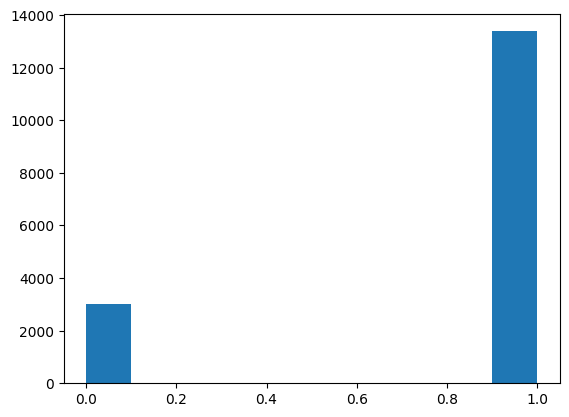

In [56]:
plt.hist(max_corr_vals_smae)
plt.show()

In [57]:
sum(max_corr_vals_smae) / len(max_corr_vals_smae)

0.8166645022683952

## cross model corr

In [58]:
max_corr_inds, max_corr_vals = batched_correlation(word_dim_output_sae, word_dim_output_sae_2)

In [61]:
word_dim_output_sae.shape

torch.Size([5123, 16384])

In [62]:
word_dim_output_sae_2.shape

torch.Size([5123, 32768])

In [60]:
len(max_corr_inds)

32768

In [63]:
len(set(max_corr_inds))

2611

In [64]:
sum(max_corr_vals) / len(max_corr_vals)

0.21823079105729448

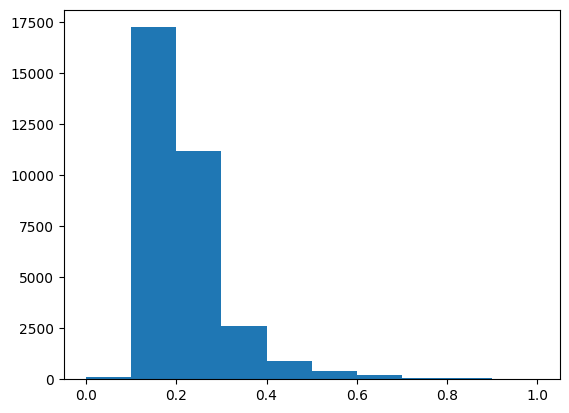

In [65]:
plt.hist(max_corr_vals)
plt.show()

In [66]:
svcca(weight_matrix_np[max_corr_inds], weight_matrix_2, "nd")

0.03594409837969318

In [67]:
sorted_feat_counts = Counter(max_corr_inds).most_common()
kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count == 1]

oneToOne_A = []
oneToOne_B = []
seen = set()
for ind_B, ind_A in enumerate(max_corr_inds):
    if ind_A in kept_modA_feats:
        oneToOne_A.append(ind_A)
        oneToOne_B.append(ind_B)
    elif ind_A not in seen:  # only keep one if it's over count X
        seen.add(ind_A)
        oneToOne_A.append(ind_A)
        oneToOne_B.append(ind_B)
num_unq_pairs = len(list(set(oneToOne_A)))
print("% unique: ", num_unq_pairs / len(oneToOne_A))
print("num feats after 1-1: ", len(oneToOne_A))

% unique:  1.0
num feats after 1-1:  2611


In [68]:
# paired right
svcca(weight_matrix_np[oneToOne_A], weight_matrix_2[oneToOne_B], "nd")

0.020324324667724714

In [ ]:
num_runs = 1
num_feats = len(oneToOne_A)
rand_scores = shuffle_rand(num_runs, weight_matrix_np[oneToOne_A],
                                    weight_matrix_2[oneToOne_B], num_feats,
                                    svcca, shapereq_bool=True)
# dictscores["svcca_rand_mean"] =
sum(rand_scores) / len(rand_scores)

0.012006638405185639

## swithc corr args order

In [70]:
max_corr_inds, max_corr_vals = batched_correlation(word_dim_output_sae_2, word_dim_output_sae)

In [71]:
word_dim_output_sae.shape

torch.Size([5123, 16384])

In [73]:
word_dim_output_sae_2.shape

torch.Size([5123, 32768])

In [72]:
len(max_corr_inds)

16384

In [74]:
len(set(max_corr_inds))

2424

In [75]:
sum(max_corr_vals) / len(max_corr_vals)

0.2512468634754441

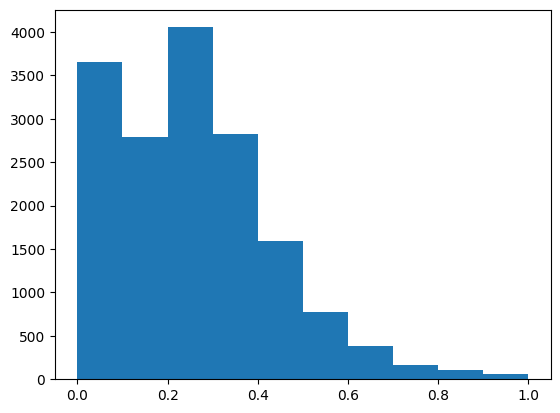

In [76]:
plt.hist(max_corr_vals)
plt.show()

In [78]:
svcca(weight_matrix_np, weight_matrix_2[max_corr_inds], "nd")

0.1246837603874768

In [87]:
num_runs = 1
num_feats = len(max_corr_inds)
rand_scores = shuffle_rand(num_runs, weight_matrix_np,
                                    weight_matrix_2, num_feats,
                                    svcca, shapereq_bool=True)
# dictscores["svcca_rand_mean"] =
sum(rand_scores) / len(rand_scores)

0.0025162416364547637

In [84]:
sorted_feat_counts = Counter(max_corr_inds).most_common()
kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count == 1]

oneToOne_A = []
oneToOne_B = []
seen = set()
for ind_A, ind_B in enumerate(max_corr_inds):
    if ind_B in kept_modA_feats:
        oneToOne_A.append(ind_A)
        oneToOne_B.append(ind_B)
    elif ind_B not in seen:  # only keep one if it's over count X
        seen.add(ind_B)
        oneToOne_A.append(ind_A)
        oneToOne_B.append(ind_B)
num_unq_pairs = len(list(set(oneToOne_A)))
print("% unique: ", num_unq_pairs / len(oneToOne_A))
print("num feats after 1-1: ", len(oneToOne_A))

% unique:  1.0
num feats after 1-1:  2424


In [85]:
# paired right
svcca(weight_matrix_np[oneToOne_A], weight_matrix_2[oneToOne_B], "nd")

0.03664453838714676

In [86]:
num_runs = 1
num_feats = len(oneToOne_A)
rand_scores = shuffle_rand(num_runs, weight_matrix_np[oneToOne_A],
                                    weight_matrix_2[oneToOne_B], num_feats,
                                    svcca, shapereq_bool=True)
# dictscores["svcca_rand_mean"] =
sum(rand_scores) / len(rand_scores)

0.011589937594576008

# sum actvs for tokens in each word, not mean

In [88]:
word_dim_output_sae = torch.zeros(len(all_prompts_tokenGroups_1), reshaped_activations_A.shape[-1])
orig_actvs_index = 0
word_actvs_index = 0

for token_group_to_word in all_prompts_tokenGroups_1:
    word_actvs = reshaped_activations_A[orig_actvs_index: orig_actvs_index + len(token_group_to_word)]
    word_dim_output_sae[word_actvs_index] = word_actvs.sum(dim=0)
    orig_actvs_index += len(token_group_to_word)
    word_actvs_index += 1

In [89]:
word_dim_output_sae_2 = torch.zeros(len(all_prompts_tokenGroups_1), reshaped_activations_B.shape[-1])
orig_actvs_index = 0
word_actvs_index = 0

for token_group_to_word in all_prompts_tokenGroups_2:
    word_actvs = reshaped_activations_B[orig_actvs_index: orig_actvs_index + len(token_group_to_word)]
    word_dim_output_sae_2[word_actvs_index] = word_actvs.sum(dim=0)
    orig_actvs_index += len(token_group_to_word)
    word_actvs_index += 1

## same matrix corrs

In [90]:
max_corr_inds_smae, max_corr_vals_smae = batched_correlation(word_dim_output_sae, word_dim_output_sae)

In [91]:
word_dim_output_sae

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

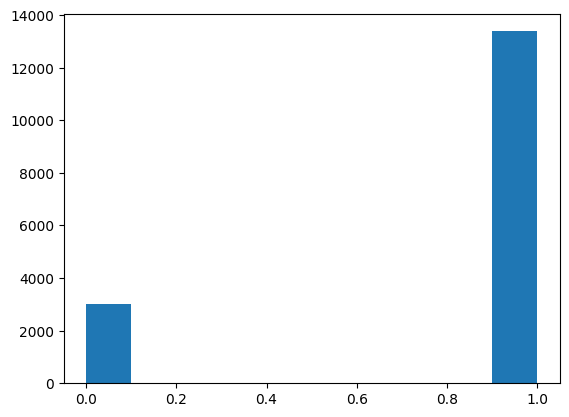

In [92]:
plt.hist(max_corr_vals_smae)
plt.show()

In [93]:
sum(max_corr_vals_smae) / len(max_corr_vals_smae)

0.816666346272541

## cross model corr

In [94]:
max_corr_inds, max_corr_vals = batched_correlation(word_dim_output_sae, word_dim_output_sae_2)

In [95]:
word_dim_output_sae.shape

torch.Size([5123, 16384])

In [96]:
word_dim_output_sae_2.shape

torch.Size([5123, 32768])

In [97]:
len(max_corr_inds)

32768

In [98]:
len(set(max_corr_inds))

2394

In [99]:
sum(max_corr_vals) / len(max_corr_vals)

0.24531793120036127

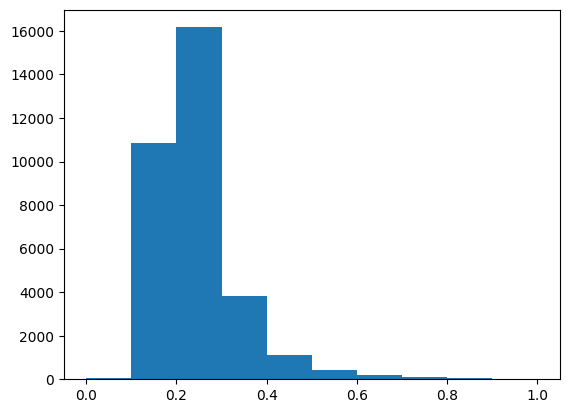

In [100]:
plt.hist(max_corr_vals)
plt.show()

In [101]:
svcca(weight_matrix_np[max_corr_inds], weight_matrix_2, "nd")

0.037642189761701327

In [102]:
sorted_feat_counts = Counter(max_corr_inds).most_common()
kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count == 1]

oneToOne_A = []
oneToOne_B = []
seen = set()
for ind_B, ind_A in enumerate(max_corr_inds):
    if ind_A in kept_modA_feats:
        oneToOne_A.append(ind_A)
        oneToOne_B.append(ind_B)
    elif ind_A not in seen:  # only keep one if it's over count X
        seen.add(ind_A)
        oneToOne_A.append(ind_A)
        oneToOne_B.append(ind_B)
num_unq_pairs = len(list(set(oneToOne_A)))
print("% unique: ", num_unq_pairs / len(oneToOne_A))
print("num feats after 1-1: ", len(oneToOne_A))

% unique:  1.0
num feats after 1-1:  2394


In [103]:
# paired right
svcca(weight_matrix_np[oneToOne_A], weight_matrix_2[oneToOne_B], "nd")

0.016231308843653276

In [104]:
num_runs = 1
num_feats = len(oneToOne_A)
rand_scores = shuffle_rand(num_runs, weight_matrix_np[oneToOne_A],
                                    weight_matrix_2[oneToOne_B], num_feats,
                                    svcca, shapereq_bool=True)
# dictscores["svcca_rand_mean"] =
sum(rand_scores) / len(rand_scores)

0.007348526381987567

## swithc corr args order

In [105]:
max_corr_inds, max_corr_vals = batched_correlation(word_dim_output_sae_2, word_dim_output_sae)

In [106]:
word_dim_output_sae.shape

torch.Size([5123, 16384])

In [107]:
word_dim_output_sae_2.shape

torch.Size([5123, 32768])

In [108]:
len(max_corr_inds)

16384

In [109]:
len(set(max_corr_inds))

2294

In [110]:
sum(max_corr_vals) / len(max_corr_vals)

0.26276862514112054

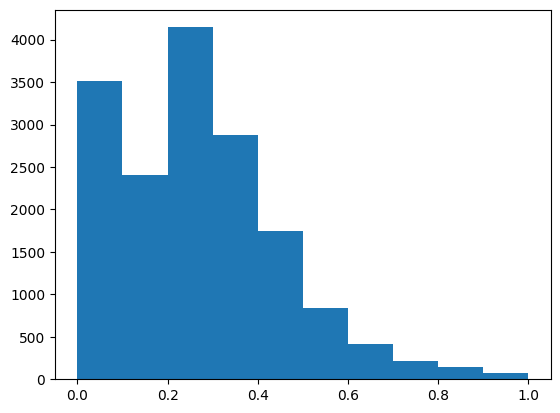

In [111]:
plt.hist(max_corr_vals)
plt.show()

In [112]:
svcca(weight_matrix_np, weight_matrix_2[max_corr_inds], "nd")

0.1290662867262166

In [113]:
num_runs = 1
num_feats = len(max_corr_inds)
rand_scores = shuffle_rand(num_runs, weight_matrix_np,
                                    weight_matrix_2, num_feats,
                                    svcca, shapereq_bool=True)
# dictscores["svcca_rand_mean"] =
sum(rand_scores) / len(rand_scores)

0.0026402454062346304

In [114]:
sorted_feat_counts = Counter(max_corr_inds).most_common()
kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count == 1]

oneToOne_A = []
oneToOne_B = []
seen = set()
for ind_A, ind_B in enumerate(max_corr_inds):
    if ind_B in kept_modA_feats:
        oneToOne_A.append(ind_A)
        oneToOne_B.append(ind_B)
    elif ind_B not in seen:  # only keep one if it's over count X
        seen.add(ind_B)
        oneToOne_A.append(ind_A)
        oneToOne_B.append(ind_B)
num_unq_pairs = len(list(set(oneToOne_A)))
print("% unique: ", num_unq_pairs / len(oneToOne_A))
print("num feats after 1-1: ", len(oneToOne_A))

% unique:  1.0
num feats after 1-1:  2294


In [115]:
# paired right
svcca(weight_matrix_np[oneToOne_A], weight_matrix_2[oneToOne_B], "nd")

0.02469315928597928

In [116]:
num_runs = 1
num_feats = len(oneToOne_A)
rand_scores = shuffle_rand(num_runs, weight_matrix_np[oneToOne_A],
                                    weight_matrix_2[oneToOne_B], num_feats,
                                    svcca, shapereq_bool=True)
# dictscores["svcca_rand_mean"] =
sum(rand_scores) / len(rand_scores)

0.01225430550115353